## 랜덤포레스트 사용하기
     Load Dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager,rc

#노트북 안아ㅔ 그래프를 그리기 위해 
%matplotlib inline

#그리프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

#그래프 글꼴 설정
path = 'C:/Windows/Fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=path).get_name()
rc('font',family=font_name)

In [2]:
train = pd.read_csv('C://BigData/Kaggle/Bike_Sharing_Demand/train.csv',parse_dates=['datetime'])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv('C:/BigData/Kaggle/Bike_Sharing_Demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

### Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

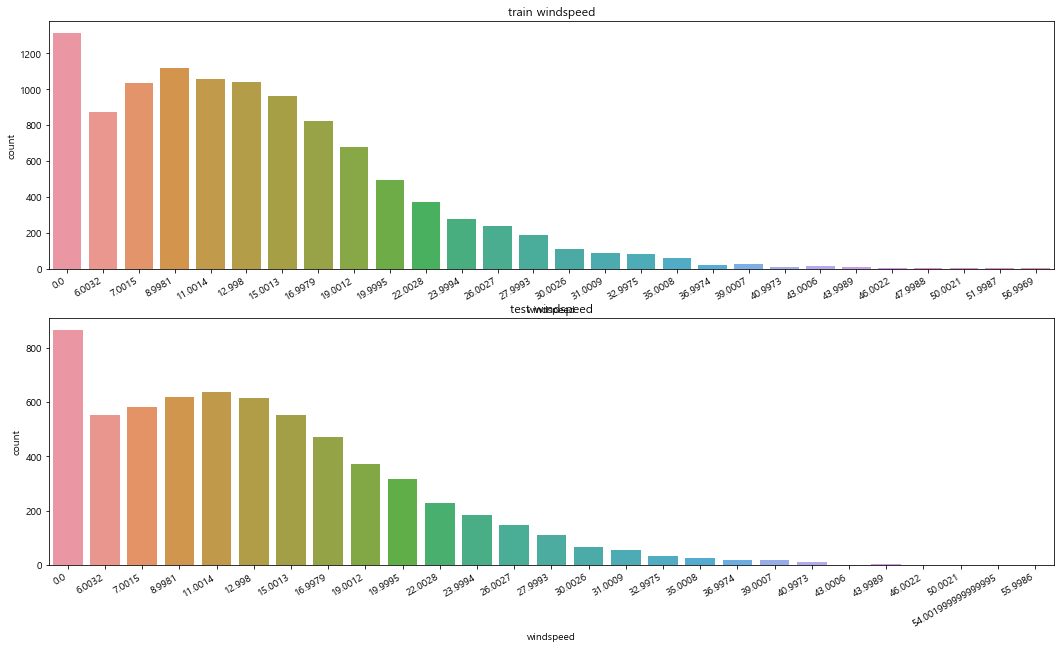

In [6]:
# widspeed  풍속에 0 값이 가장 많다 -> 잘못 기록된 데이터를 고쳐 줄 필요가 있음.
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

 - 풍속의 0 값에 특정 값을 넣어준다.
 - 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될 것 같진 않다.
 - train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
 - test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [7]:
# 풍속이 0인 것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [8]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

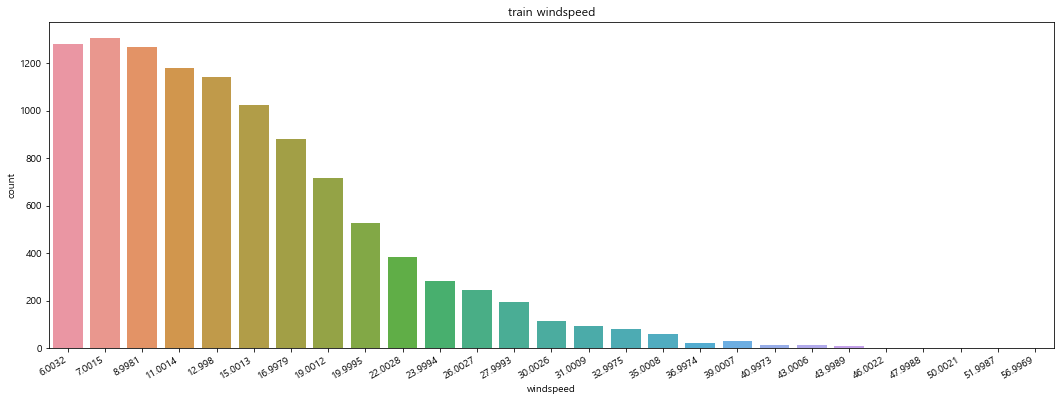

In [9]:
# 0값을 조절한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# windspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

## Feature Selection
 - 신호와 잡음을 구분해야 한다.
 - 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다. 
 - 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [10]:
# 연속형 feature 와 범주형 feature
# 연속형 feature = ['temp', 'humidity','windspeed','atemp']
# 범주형 feature의 type을 category로 변경해 준다.
categorical_feature_names=['season','holiday','workingday','weather', 'dayofweek','month','year','hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [11]:
feature_names = ['season','weather','temp','atemp','humidity','windspeed','year','hour',
                 'dayofweek','holiday','workingday']

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [12]:
x_train = train[feature_names]

print(x_train.shape)
x_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [14]:
x_test = test[feature_names]

print(x_test.shape)
x_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [15]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## Score

### RMSLE

과대평가 된 항목보다는 과소평가 된 항목에 페널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높다.

0에 가까운 값이 나올수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}n (\log(p_i + 1) - \log(a_i+1))2 } $$

- \({n}\) is the number of hours in the test set
- \(p_i\) is your predicted count
- \(a_i\) is the actual count
- \(\log(x)\) is the natural logarithm

- 잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소평가 된 항목에 페널티를 주기 위해

- 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클수록 오차가 크다는 의미다.

- 값이 작을수록 오류가 적다는 의미를 나타낸다.

In [16]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다. 
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    #예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    #위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    #평균을 낸다.
    mean_difference = difference.mean()
    
    #다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Cross Validation 교차검증

 - 일반화 성능을 측정하기 위해 데이터를 여러번 반복해서 나누고 여러 모델을 학습한다.
 - KFold 교차검증
  - 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
  - 첫번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련 세트로 사용하여 학습한다.
  - 나머지 훈련 세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
  - 다음은 두번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련 세트를 두번째 폴드로 정확도를 측정한다.
  - 이 과정을 마지막 폴드까지 반복
  - 이렇게 훈련 세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균값을 낸 게 정확도가 된다.

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# RandomForest

In [20]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model= RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [21]:
%time score = cross_val_score(model, x_train, y_train, cv = k_fold, scoring=rmsle_scorer)

score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score = {0:.5f}".format(score))

Wall time: 36.8 s
Score = 0.33152


## Train

In [22]:
# 학습시킴, 피팅 - 피처와 레이블을 넣어주면 알아서 학습함
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
#Predict
predictions = model.predict(x_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.36,   4.97,   4.22,   3.41,   3.11,   6.29,  38.42, 105.85,
       236.23, 136.65])

[Text(0.5, 1.0, 'test')]

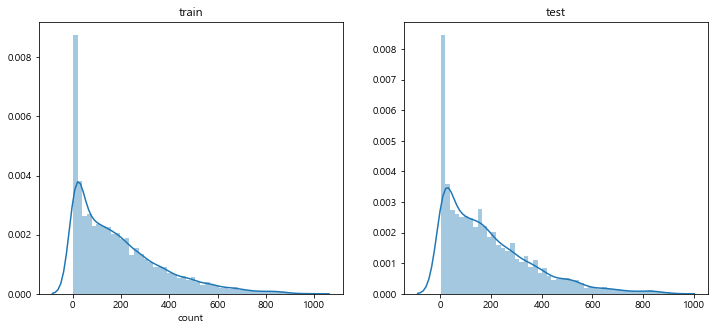

In [24]:
# 예측한 데이터를 시각확
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

## Submit

In [25]:
submisstion = pd.read_csv("C://BigData/Kaggle/Bike_Sharing_Demand/sampleSubmission.csv")
submisstion

submisstion['count'] = predictions

print(submisstion.shape)
submisstion.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.36
1,2011-01-20 01:00:00,4.97
2,2011-01-20 02:00:00,4.22
3,2011-01-20 03:00:00,3.41
4,2011-01-20 04:00:00,3.11


In [26]:
submisstion.to_csv("C://BigData/Kaggle/Bike_Sharing_Demand/Score_{0:.5f}_submission.csv".format(score), index=False)